<a href="https://colab.research.google.com/github/vivekvardhannali/predicting_the_failrate/blob/main/failure_rate_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import requests
import zipfile
import io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split#
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [24]:
#taking the data and checking if there are some errors
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'
response=requests.get(zip_url)
if response.status_code == 200:
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        with thezip.open('student-por.csv') as myfile:
            df_por = pd.read_csv(myfile, sep=';')#conversion of csv into dataframe
        with thezip.open('student-mat.csv') as myfile:
            df_mat = pd.read_csv(myfile, sep=';')
    df = pd.concat([df_por, df_mat], axis=0)
else:
    print("Failed to download the file")



In [25]:
#exploratory data analysis(EDA)
print(df.head())
print(df.describe())
print(df.isnull().sum())#isnull checks if there is any empty cell and sum accumulates all true values add it in one coloumn
print(df.info())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        4   0  11  11  
1      5        3      3     1     1      3        2   9  11  11  
2      4        3      2     2     3      3        6  12  13  12  
3      3        2      2     1     1      5        0  14  14  14  
4      4        3      2     1     2      5        0  11  13  13  

[5 rows x 33 columns]
               age         Medu         Fedu   traveltime    studytime  \
count  1044.00

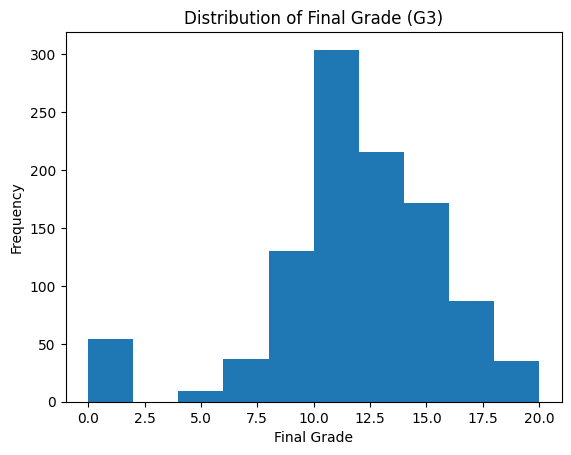

In [26]:
#plotting the data training data set
plt.hist(df['G3'])
plt.title('Distribution of Final Grade (G3)')
plt.xlabel('Final Grade')
plt.ylabel('Frequency')
plt.show()


In [27]:
#to check the pass percentage i gonna convert the g3 data into classification problem
#with 40% ie 8 marks
df['G3']=(df['G3']>=8).astype(int)
#handling missing values by replacing them with mean of their feature inplace
df.fillna(df.mean(numeric_only=True),inplace=True)
#handling missing values of object types by the modes of those feature
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].fillna(df[column].mode()[0])
print(df)


    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

In [28]:
#encoding
#use label encoder on any categorical variable and the method fit_transform in this does the job
# Encode binary categorical variables using LabelEncoder
binary_vars = ['school', 'sex', 'address', 'famsize', 'Pstatus',
               'schoolsup', 'famsup', 'paid', 'activities',
               'nursery', 'higher', 'internet', 'romantic']
for var in binary_vars:
    le = LabelEncoder()
    df[var] = le.fit_transform(df[var])
# Encode nominal categorical variables using get_dummies
nominal_vars = ['Mjob', 'Fjob', 'reason', 'guardian']

df = pd.get_dummies(df, columns=nominal_vars, drop_first=True)
print(df.select_dtypes(include=['object']).columns)
#this get dummies will create each possible value of each of the nominal_vars as a feature and assigns them with 0 or 1 or we can say it like one hot encoding

Index([], dtype='object')


In [29]:
# Normalize numeric values
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#we mustnot normalize the feature which we are going to predict
numeric_features.remove('G3')

numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('G3')
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
# Preparing the data
X = df.drop(['G3'], axis=1)
y = df['G3']
#splitting the data training set and testing set in the fraction 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.select_dtypes(include=['object']).columns)


Index([], dtype='object')


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Model training using Random Forest to decrease the overfitting problem of the decision tree model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
# Predictions and evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

from sklearn.metrics import confusion_matrix
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Accuracy:  0.9617224880382775
Confusion Matrix:
 [[ 14   7]
 [  1 187]]


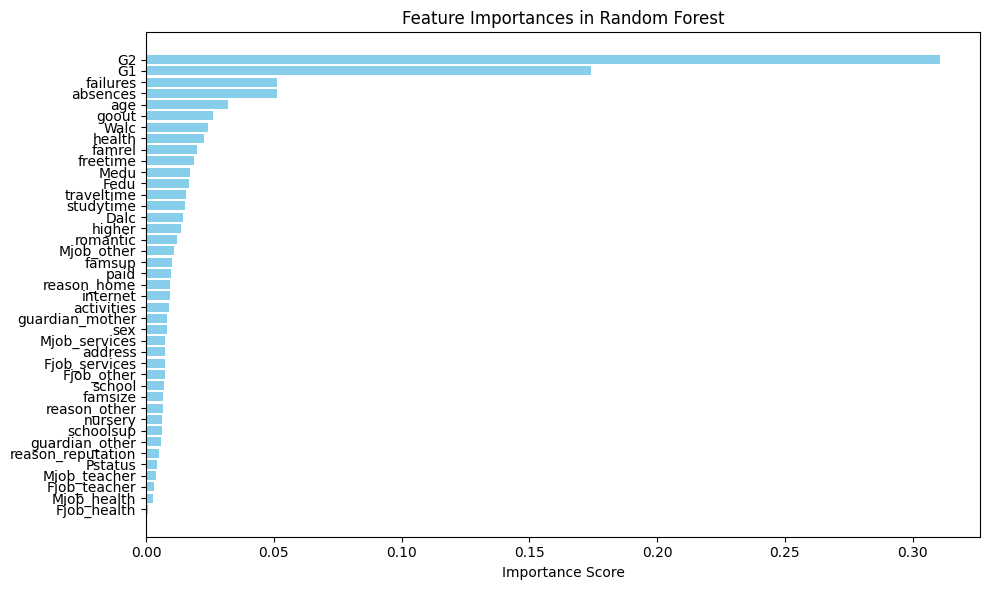

In [33]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Get corresponding feature names (assuming you're using a DataFrame)
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importances in Random Forest')
plt.tight_layout()
plt.show()
